# Time - Frequency Analysis with Borehole Data

# Moving window analysis

One way to analyse the time-varying frequency content of a signal is to
apply windows in the time domain to the signal and to calculate a Fourier spectrum
of the windowed part. The window marches along the signal with defined overlap creating
a series of Fourier spectra associated with the center times of the windows. The resulting amplitude
spectra are the plotted versus window center time. In more detail:

1. Choose windowing functions: $w(t,t_m)$ with $t_m$ the center of the window.
2. Multiply windowing function with time series: $f_m(t) = f(t)w(t,t_m)$
3. Detrend the windowed signal.
4. Perform a DFT: $F_{km} = \Delta t\sum_{n=0}^N f_m(t)\exp(-2\pi i \frac{kn}{N})$
    and calculate the absolute value, $|F_{km}|$.
5. Plot the resulting matrix: $|F_{km}|$ in the time-frequency plane.

# Borehole Data and Test Site

Within the scope of constructing new buildings for the International Geothermal Center in Bochum in 2013 wells were drilled for the installation of a geothermal heat exchanger. Bore holes were drilled next to the newly constructed building (Station GEO3). A downhole hammer was used with a diameter of 152 mm. The drill bit operates by water flushing through the drill rod. The water flow rate determines the working frequency of the hammer.

To observe the drill bit noise a temporarily operating 2-D seismic network was installed around the drill site. Here, the noise of the used downhole hammer is investigated. An array of 16 seismological stations was installed in the test site. Four Mark L-4C-3D 1 Hz sensors, eight S-13 1 Hz sensors, one GS-13 1 Hz sensor and two Güralp CMG-3ESPC broad-band 120 sec – 50 Hz sensors were in use. Additionally an accelerometer was fixed to the drill rod (GEO11, blue triangle).

Some of the stations were positioned within one of the infrastructure tunnels servicing the university containing water conduits, long-distance heat line and electric cables (e.g. Station GEO4 and GEO05). Thus, noise could be reduced that might disturb the recordings. Other stations are located within buildings (e.g. Station GEO2 and GEO03) ore outside (e.g. Station GEO6 and GEO07).

![Stationskarte](karte3.jpg)

Drill bit noise was recorded up to the maximum drilling depth of 200 m. A drilling cycle is characterised by switching on the water pump, followed by the drilling with higher amplitude signals, that lasts several minutes. The water pump
is stopped about 5 to 15 minutes after the drilling finished depending on the drill depth.

In [ ]:
# Preparation: load packages
%matplotlib inline
from obspy.core import read
from obspy.core import UTCDateTime
import numpy as np
import matplotlib.pylab as plt
from setupFigure import SetupFigure

In [ ]:
def hann_window(dt, tlen):
    """
    Calculate samples of the Hann window for given DT and TLEN.
    Number of samples is assumed to be int(tlen/dt)
    :param dt: sampling interval
    :param tlen: length of window
    """
    ns = int(tlen/dt)
    return 2*np.sin(np.pi*dt*np.arange(0, ns)/tlen)**2

In [ ]:
def boxcar_window(dt, tlen):
    """
    Calculates samples of a boxcar window (all ones)
    Number of samples is assumed to be int(tlen/dt)
    :param dt: sampling interval
    :param tlen: length of window
    """
    ns = int(tlen/dt)
    return np.ones(ns)

In [ ]:
def movingWindowAnalysis(data, dt, winfun, twinlen, tmove):
    """
    Performs moving window analysis of a time series.
    :param data: data array
    :param dt: sampling interval (seconds)
    :param winfun: name of the window function to be called
    :param twinlen: window length (seconds)
    :param tmove: displacement of moving window in seconds
    """
    fwin = winfun(dt, twinlen)             # compute window values
    nwin = fwin.size                       # nuber of window samples
    ndata = len(data)                      # number of data samples
    nseg = int((ndata-nwin)*dt/tmove)+1       # total number of expected data segments
    mwa = np.zeros((nwin//2+1,nseg))       # array for resulting matrix (rfft returns N/2+1 samples)  
    ka = 0                                 # start index of data segment
    ke = nwin                              # end index of data segment
    jseg = 0                               # initialize data segment counter
    while ke < ndata:                      # loop over segments
        seg = data[ka:ke]                          # get data segment
        seg = (seg-seg.mean())*fwin                # subtract mean value of segment and multiply with window
        ftseg = np.abs(np.fft.rfft(seg))           # abs value of Fourier transform
        maxft = np.amax(ftseg)                     # max value of Fourier transform
        ftseg = ftseg/maxft+1.e-10                 # normalize spectrum to its maximum, remove zeros
        mwa[:,jseg] = np.power(ftseg,1.0)          # assign values to the matrix
        ka = ka+int(tmove/dt)                      # move window start
        ke = ke+int(tmove/dt)                      # move window end by shift
        jseg = jseg+1                              # increase segment counter
    return nseg, mwa                         # return number of segments and moving window matrix

## Reading and preparing the data to analyze

In [36]:
# data from stations, Jan 23 2013

record = '1300'                                     # either use record starting at 1300 or 1400
datapath = 'geo2.' + record+ '.HHZ'

if record =='1300':
    stime = UTCDateTime('2013-01-23 13:16:00Z')      # use record starting at 1300
    etime = UTCDateTime('2013-01-23 13:25:00Z')
    ttitle = ', depth: 36.5 m'
else:
    stime = UTCDateTime('2013-01-23 14:10:00Z')      # use record starting at 1400 (14:14-14:23)
    etime = UTCDateTime('2013-01-23 14:20:00Z')
    ttitle = ', depth: 56.5 m'
    
st = read(datapath)                                  # read file using obspy read

st.trim(stime,etime)      # trim data stream to desired start and end time
st.detrend('linear')      # do a linear detrending
st.detrend('demean')      # subtract mean value

1 Trace(s) in Stream:
en.e3987.11.HHZ | 2013-01-23T13:16:00.000000Z - 2013-01-23T13:25:00.000000Z | 500.0 Hz, 270001 samples

## Plot the seismogram

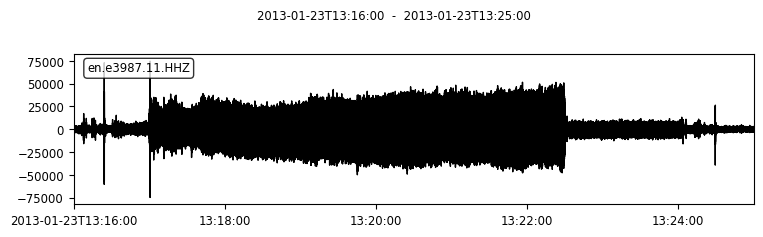

In [37]:
tr = st[0]                # extract first trace from stream (there is only one)
tr.plot();                # plot trace

In [ ]:
# Cell 2: Preparation of window
twinlen = 5.0                                # window length in seconds
ndata = tr.stats.npts                        # number of samples
dt = tr.stats.delta                          # sampling interval

print("Sampling interval: ",dt)
print("Length of trace [s]: ",ndata*dt)

In [ ]:
# Plot the window function and its effect on the time series

fwin = hann_window(dt, twinlen)           # Hann window
fig1, ax1 = SetupFigure(15, 3, "Time", "Amplitude", "Hann window", 14)
ax1.plot(fwin,'-k')
seg = tr.data[0:fwin.size]*fwin          # multiply data with window
fig2, ax2 = SetupFigure(15, 3, "Time", "Data", "Data * Hann window", 14)
ax2.plot(seg,'-k')

fwin = boxcar_window(dt, twinlen)         # Boxcar window
fig3, ax3 = SetupFigure(15, 3, "Time", "Amplitude", "Boxcar window", 14)
ax3.plot(fwin,'-k')
seg = tr.data[0:fwin.size]*fwin  # multiply data with window
fig4, ax4 = SetupFigure(15, 3, "Time", "Data", "Data * Boxcar window", 14)
ax4.plot(seg,'-k')

In [ ]:
# carry out the moving window analysis
tmove = 0.2*twinlen
nseg, mwa = movingWindowAnalysis(tr.data, dt, hann_window, twinlen, tmove)   # compute spectrogram
freq = np.fft.rfftfreq(fwin.size,dt)                            # Fourier frequencies
print("Frequency range [Hz]: ",freq[0],freq[-1])

In [ ]:
# plot the result
fmaxplot = 100                                                # maximum frequency to be plotted
nf = len(freq)                                                # number of frequencies
jfmax = int(fmaxplot/freq[-1]*nf)                             # max index for plotting   
extent = (0.5*twinlen, 0.5*twinlen+nseg*tmove, fmaxplot, 0.)     # extent of matrix in true time and frequency
fig5, ax5 = SetupFigure(15, 10, "Window center time [s]", "Frequency [Hz]", "Moving window analysis", 14)
ax5.imshow(mwa[0:jfmax,:],extent = extent, aspect=2.0)        # do plotting

# Tasks

1. Use the sqrt of the Fourier amplitude spectrum as output and compare
2. Use other powers ($< 1$) of the Fourier amplitude (using np.power)
3. Use the logarithm of the Fourier amplitude as output and compare (using np.log)
4. Extend the frequency range when using the logarithm or a power of the Fourier amplitude
5. Do a moving window analysis the records at 14:00.
6. Compare the performance of boxcar and Hann window

**Hint:** when you change something in the code, use `Run all below` to see the changes.